In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import pickle
from jupyterthemes import jtplot
jtplot.style('oceans16')

# Position Change to the Nearest Car between Frames

In [2]:
t1 = torch.load('../traffic-data/state-action-cost/data_i80_v0/trajectories-0400-0415/all_data.pth')
t2 = torch.load('../traffic-data/state-action-cost/data_i80_v0/trajectories-0500-0515/all_data.pth')
t3 = torch.load('../traffic-data/state-action-cost/data_i80_v0/trajectories-0515-0530/all_data.pth')
t_states_full = t1['states'] + t2['states'] + t3['states']

In [3]:
def get_xy_diff_with_closest_car(episode):
    dists_t = torch.sqrt((episode[:, 0, :2][:, None, :] - episode[:, 1:, :2]).norm(2, dim=-1))
    dists_t[dists_t<=1e-7] = 999999  # if there is no car there
    min_dists_t_idx = dists_t.argmin(dim=-1)
    dist_diff = (dists_t[1:] - dists_t[:-1])
    return dist_diff.gather(dim=1, index=min_dists_t_idx[:-1].view(-1,1)).view(-1)

In [4]:
xy_diffs = torch.cat([
    get_xy_diff_with_closest_car(k) for k in t_states_full
])

velocity = torch.cat(
    [k[:-1] for k in t_states_full]
)[:, 0, 2:].norm(2, dim=-1)
# velocity *= 4*3.7/24 * 3.6

velocity_np = (velocity // 5 * 5).int().numpy()
xy_diffs_np = xy_diffs.numpy()

In [5]:
df = pd.DataFrame({'velocity':velocity_np, 'position_diff': -xy_diffs_np})

In [6]:
df_new = df[df['position_diff']>1e-7].copy()
df_new['position_diff'] = np.log10(df_new['position_diff'])

Text(0.5, 0, 'speed')

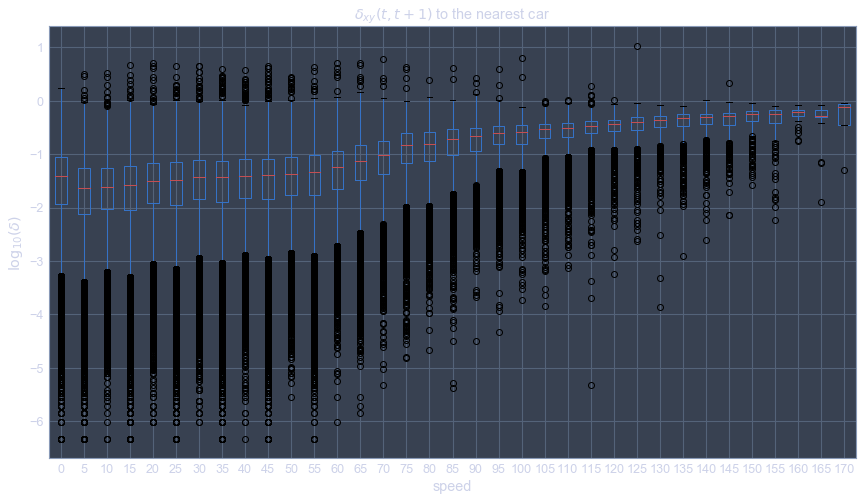

In [7]:
df_new.boxplot(column='position_diff', by='velocity', figsize=(14,8),)
plt.title("$\delta_{xy}(t, t+1)$ to the nearest car")
plt.suptitle("")
plt.ylabel('$\log_{10}(\delta)$')
plt.xlabel('speed')

# Gradients wrt Actions

In [3]:
act_grads = torch.load('../actions_grads_orig.pkl')
data = [np.array(k) for k in act_grads]
data = np.concatenate(data, axis=0)
xedges = [np.quantile(data[:,0], p) for p in np.linspace(0,1,21)]

df = pd.DataFrame(data)
df.columns = ['speed', 'grad_proximity', 'grad_lane']
df.speed = (df.speed//5 * 5).astype(int)

## Non-Constant Slope

In [4]:
df_new = df.copy()

Text(0.5, 0, 'speed (km/h)')

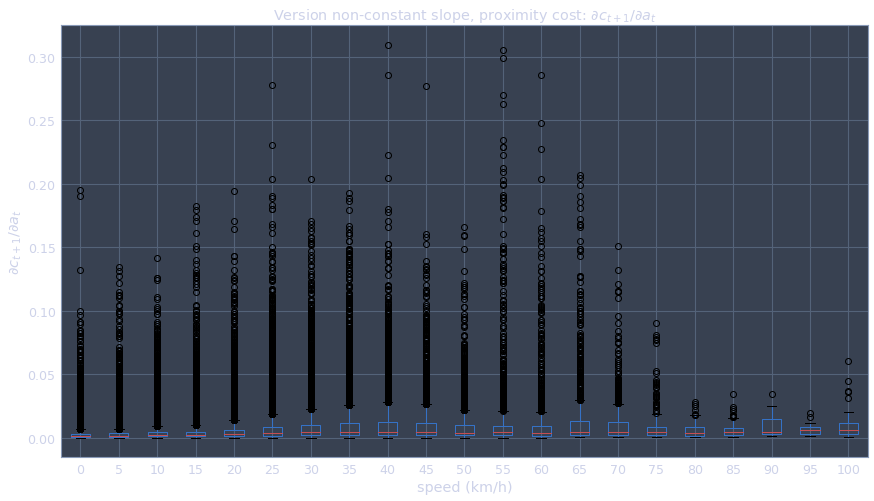

In [5]:
df_new.boxplot(column='grad_proximity', by='speed', figsize=(14,8),)
plt.title("Version non-constant slope, proximity cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\partial c_{t+1} / \partial a_t$')
plt.xlabel('speed (km/h)')

Text(0.5, 0, 'speed (km/h)')

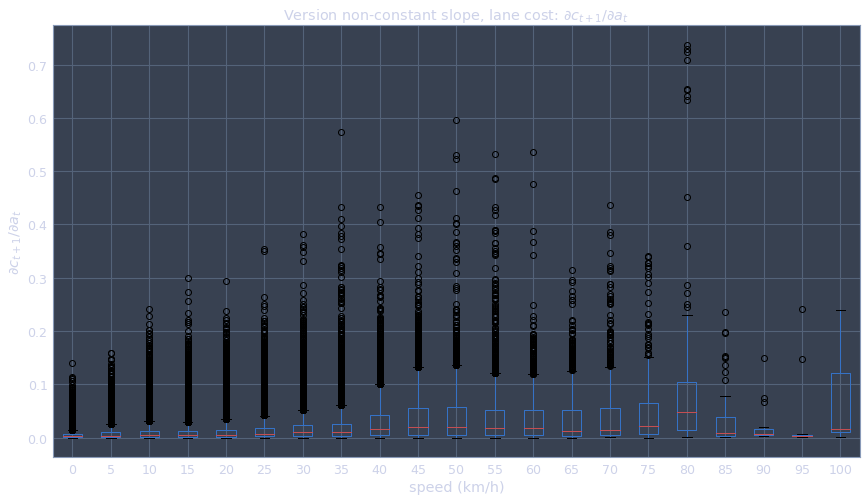

In [6]:
df_new.boxplot(column='grad_lane', by='speed', figsize=(14,8))
plt.title("Version non-constant slope, lane cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\partial c_{t+1} / \partial a_t$')
plt.xlabel('speed (km/h)')

In [7]:
df_new[['grad_proximity', 'grad_lane']] = np.log10(df_new[['grad_proximity', 'grad_lane']])

(-5, 1.2)

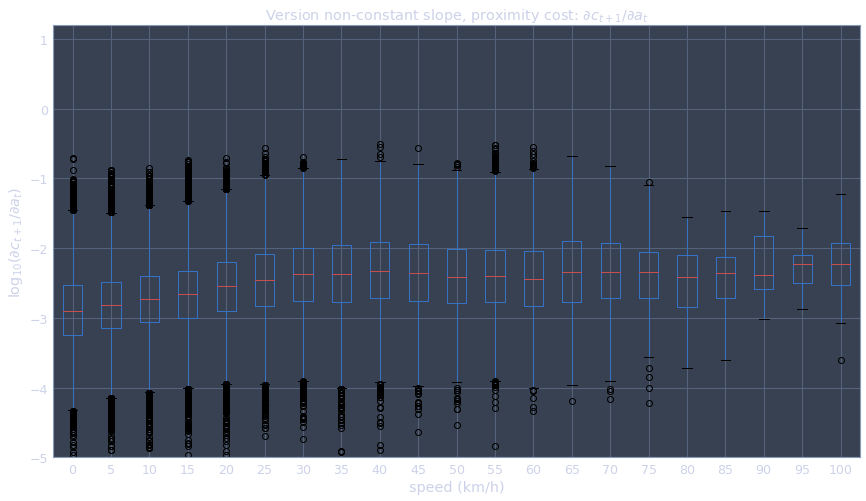

In [8]:
df_new.boxplot(column='grad_proximity', by='speed', figsize=(14,8))
plt.title("Version non-constant slope, proximity cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\log_{10}(\partial c_{t+1} / \partial a_t)$')
plt.xlabel('speed (km/h)')
plt.ylim(-5, 1.2)

Text(0.5, 0, 'speed (km/h)')

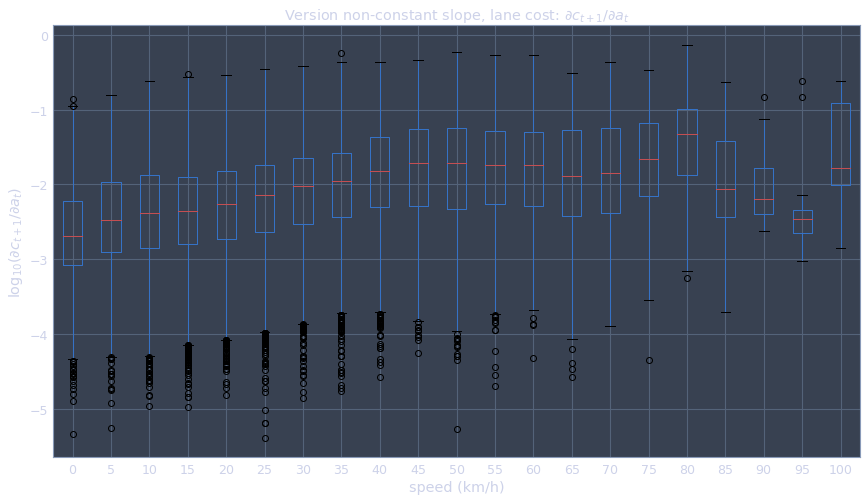

In [9]:
df_new.boxplot(column='grad_lane', by='speed', figsize=(14,8))
plt.title("Version non-constant slope, lane cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\log_{10}(\partial c_{t+1} / \partial a_t)$')
plt.xlabel('speed (km/h)')

## Constant Slope

In [10]:
act_grads = torch.load('../actions_grads.pkl')
data = [np.array(k) for k in act_grads]
data = np.concatenate(data, axis=0)
xedges = [np.quantile(data[:,0], p) for p in np.linspace(0,1,21)]

df = pd.DataFrame(data)
df.columns = ['speed', 'grad_proximity', 'grad_lane']
df.speed = (df.speed//5 * 5).astype(int)

In [11]:
df_new = df.copy()

Text(0.5, 0, 'speed (km/h)')

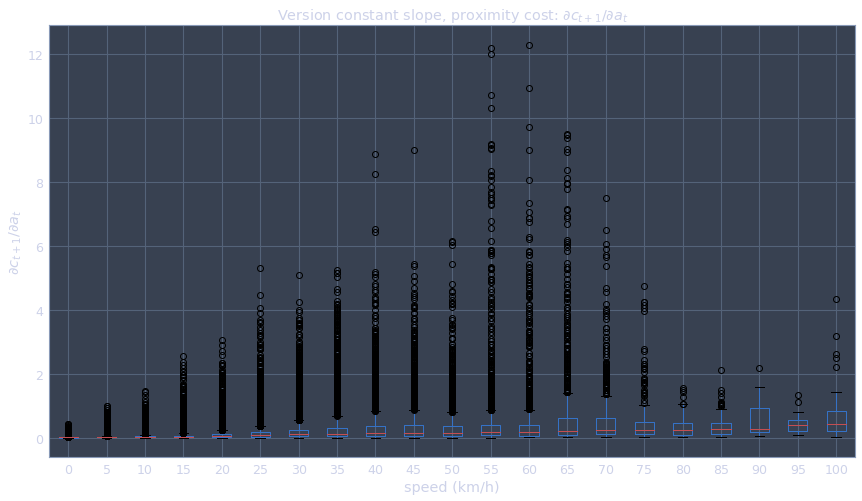

In [12]:
df_new.boxplot(column='grad_proximity', by='speed', figsize=(14,8),)
plt.title("Version constant slope, proximity cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\partial c_{t+1} / \partial a_t$')
plt.xlabel('speed (km/h)')

Text(0.5, 0, 'speed (km/h)')

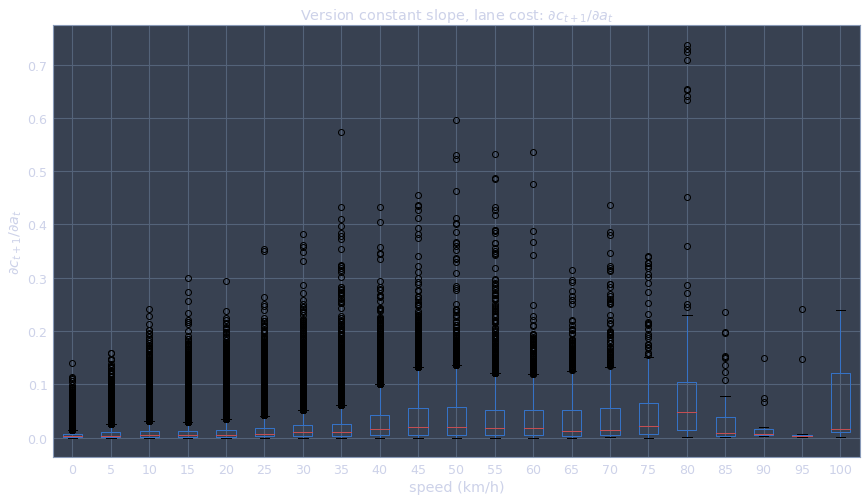

In [13]:
df_new.boxplot(column='grad_lane', by='speed', figsize=(14,8))
plt.title("Version constant slope, lane cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\partial c_{t+1} / \partial a_t$')
plt.xlabel('speed (km/h)')

In [14]:
df_new[['grad_proximity', 'grad_lane']] = np.log10(df_new[['grad_proximity', 'grad_lane']])

(-5, 1.2)

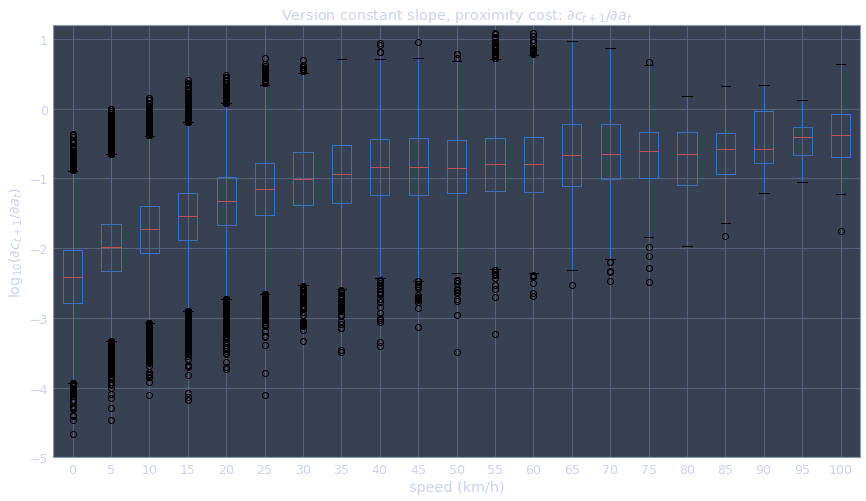

In [15]:
df_new.boxplot(column='grad_proximity', by='speed', figsize=(14,8))
plt.title("Version constant slope, proximity cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\log_{10}(\partial c_{t+1} / \partial a_t)$')
plt.xlabel('speed (km/h)')
plt.ylim(-5, 1.2)

Text(0.5, 0, 'speed (km/h)')

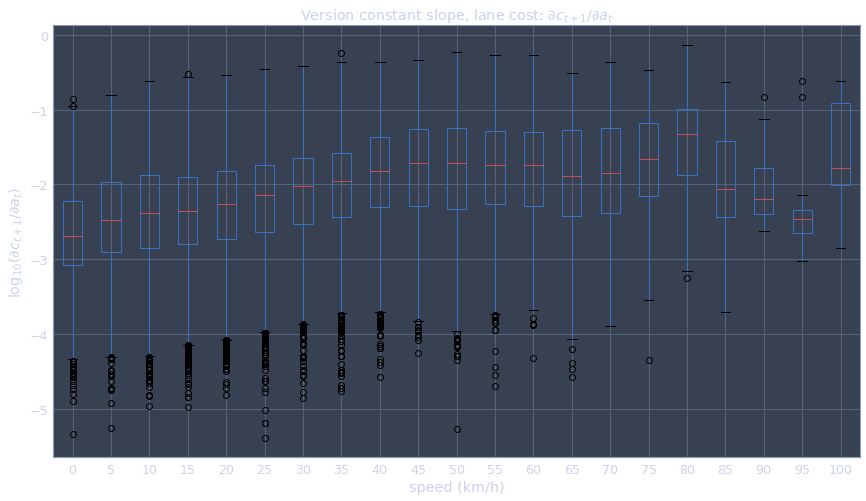

In [16]:
df_new.boxplot(column='grad_lane', by='speed', figsize=(14,8))
plt.title("Version constant slope, lane cost: $\partial c_{t+1} / \partial a_t$ ")
plt.suptitle("")
plt.ylabel('$\log_{10}(\partial c_{t+1} / \partial a_t)$')
plt.xlabel('speed (km/h)')